# This notebook demonstrates PID
## training with a basic edgeconv vs dynamic reduction graph networks

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
import torch_geometric
import torch
import os
import os.path as osp
import numpy as np
from tqdm import tqdm as tqdm
from torch_geometric.data import Data
torch.manual_seed(1)

## Load arrays

In [3]:
### format evno, x, y, z, l, t, e
phoar = np.load("phoarray.npy")
#piar = np.load("piarrayp80.npy")
piar = np.load("piarrayp80.npy")

## Transform data to torch_geometric format

In [4]:
def makedatslist(inputarray,nlay,label):
    datalist = []
    for evts in tqdm(np.unique(inputarray[:,0])):
        evar = inputarray[inputarray[:,0] == evts]
        evar_sel = evar[evar[:,4] <= nlay ]
        evar_sel = evar_sel[:,[1,2,3,5,6]] ### train data feats : x,y,z,t,e
        datalist.append(Data(x = torch.tensor(evar_sel, dtype=torch.float32),y = torch.tensor([int(label)])))
    return datalist

In [5]:
phodatalist = makedatslist(phoar,30,0) 
print("phodatasetsize:",len(phodatalist))
pidatalist = makedatslist(piar,30,1) 
print("pidatasetsize:",len(pidatalist))

100%|██████████| 1000/1000 [00:05<00:00, 183.03it/s]


phodatasetsize: 1000


100%|██████████| 609/609 [00:01<00:00, 387.40it/s]

pidatasetsize: 609


## Split dataset into train and test

In [6]:
traindata = pidatalist[:500] + phodatalist[:500]
testdata = pidatalist[500:] + phodatalist[500:500+len(pidatalist[500:])]

print(len(traindata),len(testdata))

import random
random.shuffle(traindata)
ntrainbatch = 50
ntestbatch = 50
trainloader = torch_geometric.data.DataLoader(traindata, batch_size=ntrainbatch)
testloader = torch_geometric.data.DataLoader(testdata, batch_size=ntestbatch)

1000 218


## Simple EdgeConv network

In [7]:
### define the network

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)


transform = T.Cartesian(cat=False)



class PIDNetwork(nn.Module):
    
    def __init__(self, input_dim=24, hidden_dim=50, output_dim=2, k=16, aggr='add' ):#,
                 #norm=torch.tensor([1./100., 1./100., 1./300., 1./100.])):
                 
        super(PIDNetwork, self).__init__()
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        ### input net takes to higher dim representation
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim//2),            
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ELU(),
            
        )
        
        ## nets used in edgeconv
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        
        ## define the edgeconv network       
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        
        
        ## output network to get class predictions
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim*2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_dim*2, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )

    ### data flow    
    def forward(self, data): 
        #data.x = self.datanorm * data.x
        
        data.edge_index = to_undirected(knn_graph(data.x[:,3], self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        
        data.x = self.inputnet(data.x)
        
        data.x = self.edgeconv1(data.x, data.edge_index)
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        
        
        
        x = self.edgeconv2(data.x, data.edge_index)
        
        x = global_mean_pool(x, data.batch)
        

        return self.output(x).squeeze(-1) 

## Dynamic Reduction Network

In [8]:
### DRN works dont change

import os
import os.path as osp
import math

import numpy as np
import torch
import gc
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.utils.checkpoint import checkpoint
from torch_cluster import knn_graph

from torch_geometric.nn import EdgeConv, NNConv

from torch_geometric.utils import normalized_cut
from torch_geometric.utils import remove_self_loops
from torch_geometric.utils.undirected import to_undirected
from torch_geometric.nn import (graclus, max_pool, max_pool_x,
                                global_mean_pool, global_max_pool,
                                global_add_pool,BatchNorm)

transform = T.Cartesian(cat=False)

def normalized_cut_2d(edge_index, pos):
    row, col = edge_index
    edge_attr = torch.norm(pos[row] - pos[col], p=2, dim=1)
    return normalized_cut(edge_index, edge_attr, num_nodes=pos.size(0))

class DynamicReductionNetwork(nn.Module):
    # This model iteratively contracts nearest neighbour graphs 
    # until there is one output node.
    # The latent space trained to group useful features at each level
    # of aggregration.
    # This allows single quantities to be regressed from complex point counts
    # in a location and orientation invariant way.
    # One encoding layer is used to abstract away the input features.
    def __init__(self, input_dim=5, hidden_dim=64, output_dim=1, k=16, aggr='add',
                 norm=torch.tensor([1./500., 1./500., 1./54., 1/25., 1./1000.])):
        super(DynamicReductionNetwork, self).__init__()

        self.datanorm = nn.Parameter(norm,requires_grad=True)
        
        self.k = k
        start_width = 2 * hidden_dim
        middle_width = 3 * hidden_dim // 2

        
        
        self.inputnet =  nn.Sequential(
            nn.Linear(input_dim, hidden_dim//2),            
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),

            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ELU(),
        )
        
        
        convnn1 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        convnn2 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
        
        convnn3 = nn.Sequential(nn.Linear(start_width, middle_width),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(middle_width, hidden_dim),                                             
                                nn.ELU()
                                )
                
        self.edgeconv1 = EdgeConv(nn=convnn1, aggr=aggr)
        self.edgeconv2 = EdgeConv(nn=convnn2, aggr=aggr)
        self.edgeconv3 = EdgeConv(nn=convnn3, aggr=aggr)
        
        self.output = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Linear(hidden_dim//2, hidden_dim//2),
                                    nn.ELU(),
                                    nn.Linear(hidden_dim//2, output_dim)
                                   )
        self.batchnorm1 = BatchNorm(hidden_dim)
        
    def forward(self, data):        
        data.x = self.datanorm * data.x
        data.x = self.inputnet(data.x)
        

        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv1.flow))
        data.x = self.edgeconv1(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        data.edge_attr = None
        data = max_pool(cluster, data)
        
        data.edge_index = to_undirected(knn_graph(data.x, self.k, data.batch, loop=False, flow=self.edgeconv2.flow))
        data.x = self.edgeconv2(data.x, data.edge_index)
        
        weight = normalized_cut_2d(data.edge_index, data.x)
        cluster = graclus(data.edge_index, weight, data.x.size(0))
        x, batch = max_pool_x(cluster, data.x, data.batch)

        x = global_max_pool(x, batch)

        return self.output(x).squeeze(-1)

## Define model and define train and test functions

In [9]:
## training

import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.data import DataLoader


## define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## simple edgeconv 
        #self.drn = PIDNetwork(input_dim=5,
        #                    hidden_dim=50, #50
        #                    k=16,#16,
        #                    #norm=torch.tensor([1./10., 1./10., 1./100., 1./10.])
        #                     )
 
        ### DRN 
        self.drn = DynamicReductionNetwork(input_dim=5,
                                           hidden_dim=30, #50
                                           k=8,#16
                                           output_dim=2,
                                           norm=torch.tensor([1., 1., 1., 1.,1.]))
    
    def forward(self, data):
        logits = self.drn(data)
        return logits
    
device = torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')

model = Net().to(device)
print(model)
## choose optimiser
optimizer = torch.optim.Adadelta(model.parameters())#, lr=1e-3, weight_decay=1e-3)

## choose loss
losscat = torch.nn.CrossEntropyLoss()    


def categorical_loss_only(outputa,trutha):
    total_loss =  losscat(outputa,trutha) 
    return total_loss


## train model
def train(epoch):
    model.train()
    #scheduler.step()
    #torch.cuda.empty_cache()
    loss = []
    
    predc = []
    truec = []
    for data in tqdm(trainloader):
            data = data.to(device)        
            
            result = model(data) ## pass data through model
            lossc = categorical_loss_only(result, data.y) ## calculate loss
            loss.append(lossc.item()) 
            lossc.backward() ## calculate gradients
            optimizer.step() ## update parameters
            optimizer.zero_grad()
            #scheduler.batch_step()
            for i in result:
                predc.append(i.detach().cpu().argmax())
            for i in data.y.detach():
                truec.append(i.detach().cpu())
            
            
    predc = np.array(predc)
    truec = np.array(truec)
    print("train accuracy  :",np.equal(predc,truec).sum()/len(truec))        
    print( 'batches for train:',len(loss)) 
    print('train loss:',np.mean(np.array(loss)))
    return np.mean(np.array(loss)) , np.equal(predc,truec).sum()/len(truec)

from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as scs
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline


## test model
def evaluate(epoch):
        """"Evaluate the model"""
        model.zero_grad()
        torch.cuda.empty_cache()
        model.eval()
        pred = []
        true = []
        loss= []
        
        correct = 0
        predc = []
        truec = []
        for data in tqdm(testloader):
            data = data.to(device)        
            result = model(data) ## pass data through model
            lossc = categorical_loss_only(result, data.y)
            loss.append(lossc.item())

            for i in result:
                predc.append(i.detach().cpu().argmax())
            for i in data.y.detach():
                truec.append(i.detach().cpu())
            
            
        #print(predc,truec)
        predc = np.array(predc)
        truec = np.array(truec)
        ## calculate accuracy
        print("accuracy  :",np.equal(predc,truec).sum()/len(truec))
        
        print('batches for test:', len(loss)) 
        print('test loss:',np.mean(np.array(loss)))

        return np.mean(np.array(loss)),np.equal(predc,truec).sum()/len(truec)
        

Net(
  (drn): DynamicReductionNetwork(
    (inputnet): Sequential(
      (0): Linear(in_features=5, out_features=15, bias=True)
      (1): ELU(alpha=1.0)
      (2): Linear(in_features=15, out_features=15, bias=True)
      (3): ELU(alpha=1.0)
      (4): Linear(in_features=15, out_features=30, bias=True)
      (5): ELU(alpha=1.0)
    )
    (edgeconv1): EdgeConv(nn=Sequential(
      (0): Linear(in_features=60, out_features=45, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=45, out_features=30, bias=True)
      (4): ELU(alpha=1.0)
    ))
    (edgeconv2): EdgeConv(nn=Sequential(
      (0): Linear(in_features=60, out_features=45, bias=True)
      (1): ELU(alpha=1.0)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=45, out_features=30, bias=True)
      (4): ELU(alpha=1.0)
    ))
    (edgeconv3): EdgeConv(nn=Sequential(
      (0): Linear(in_features=60, out_features=45, bias=True)
      (1): ELU(alpha=1.0)
     

## Loop over dataset, train and save models per epoch as well as for best loss/accuracy

In [10]:
checkpoint_dir = 'testssummerschool3/'

os.makedirs(checkpoint_dir, exist_ok=True)
best_loss = 99999999
best_acc = 0
losst = []
lossv = []
epochs = []
acc = []
acc_train = []
for epoch in range(1, 501):
    print ('epoch:',epoch)
    loss_t,acc_t = train(epoch)
    losst.append(loss_t)
    acc_train.append(acc_t)
    loss_epoch,accuracy = evaluate(epoch)
    lossv.append(loss_epoch)
    acc.append(accuracy)
    epochs.append(epoch)
    checkpoint = {
    'epoch': epoch + 1,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
    }
    
    
    
    checkpoint_file = 'model_epoch_%i.pth.tar' % ( epoch )
    torch.save(checkpoint,
                   os.path.join(checkpoint_dir,checkpoint_file ))
    ## get best loss and save model corresponding to it
    if loss_epoch < best_loss:
        best_loss = loss_epoch
        print('new best test loss:',best_loss)
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_best_loss.pth.tar' ))
    
    ## get best accuracy and save model corresponding to it
    if accuracy > best_acc:
        best_acc = accuracy
        print('new best test accuracy:',best_acc)
        torch.save(checkpoint,
                   os.path.join(checkpoint_dir,'model_checkpoint_best_accuracy.pth.tar' ))
    
    ## plot test vs train loss and accuracy every 10 epochs
    if (epoch%10 == 0):
        plt.plot(np.array(epochs),np.array(losst),c='b',label='training loss')
        plt.plot(np.array(epochs),np.array(lossv),c='r',label='testing loss')
        plt.legend()
        plt.show()
        plt.plot(np.array(epochs),np.array(acc_train),c='b',label='training acc')
        plt.plot(np.array(epochs),np.array(acc),c='r',label='testing acc')
        plt.legend()
        plt.show()
        
    break

epoch: 1


100%|██████████| 20/20 [01:31<00:00,  4.58s/it]


train accuracy  : 0.493
batches for train: 20
train loss: 1.0235704958438874


100%|██████████| 5/5 [00:10<00:00,  2.05s/it]

accuracy  : 0.5091743119266054
batches for test: 5
test loss: 0.6866703391075134
new best test loss: 0.6866703391075134
new best test accuracy: 0.5091743119266054


## Load model for inference

In [11]:
model_fname = 'model_DRN.pth.tar' ## 90% accuracy drn
#model_fname = 'model_PIDSimpleEdgeConv.pth.tar' ## 90% accuracy pidnetwork
mdl=Net().to(device)
mdl.load_state_dict(torch.load(model_fname,map_location=torch.device('cpu'))['state_dict'])
mdl.eval()
print(sum(p.numel() for p in model.parameters()))

13987


## Do evaluation

In [12]:

pred = []
true = []
predc = []
misp = []
mist = []
misen=[]
misidx = []

idx = 0
model.eval()
for data in tqdm(trainloader):
    data = data.to(device)        
    result = mdl(data)
    for i,j in zip(result,data.y.detach()):
        pred.append(i.detach().cpu())
        predc.append(i.detach().cpu()[0:2].argmax())
        true.append(j.detach().cpu())
    idx += 1

100%|██████████| 20/20 [00:47<00:00,  2.39s/it]


tpr|1-fpr|threshold 0.908 0.95 0.770068


/Users/shamik/Software/miniconda3/envs/py3613/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


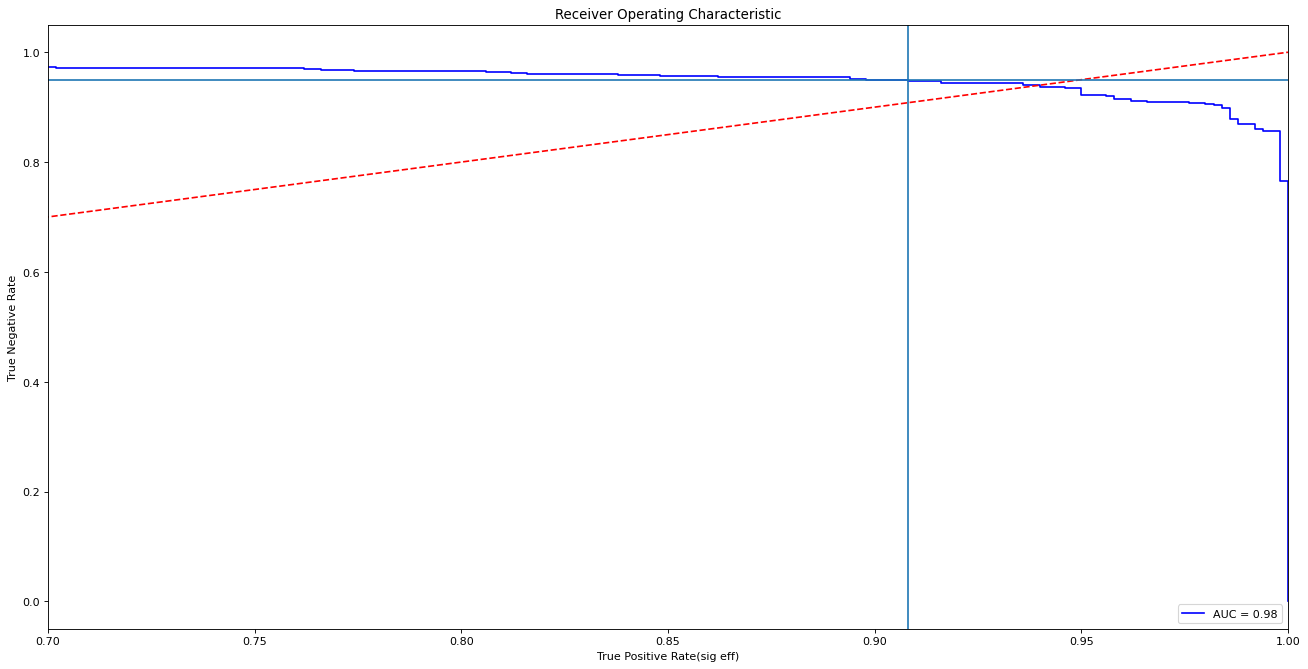

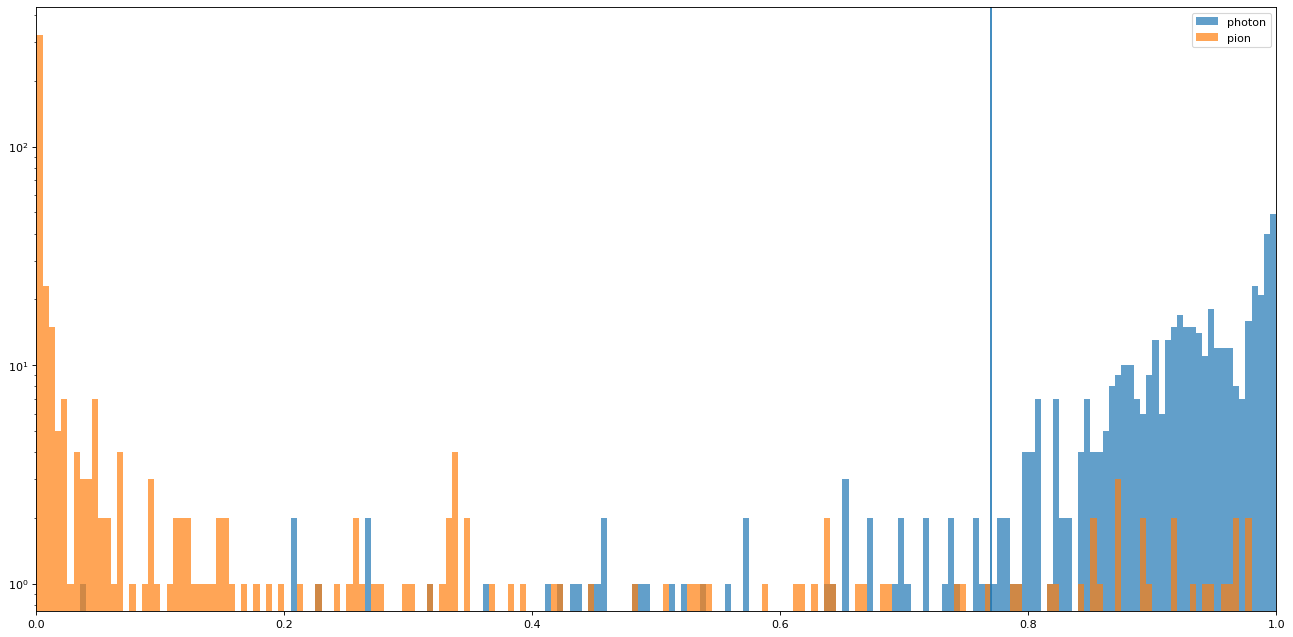

In [13]:
from matplotlib.pyplot import figure
### ROCs

figure(figsize=(20, 10), dpi=80)
preda = [F.softmax(i).numpy() for i in pred]
preda = np.array(preda)
trutha = np.array([i.numpy()  for i in true] )
#print(preda)

from sklearn import metrics


fpr, tpr, threshold = metrics.roc_curve(1-trutha, 1-preda[:,1])
roc_auc = metrics.auc(fpr, tpr)

tprv = 0
tnrv = 0
thrshv = 0
for i in range(len(fpr)):
    if (tpr[i] > 0.90 ):
        print("tpr|1-fpr|threshold",tpr[i],1-fpr[i],threshold[i])
        tprv = tpr[i]
        tnrv = 1-fpr[i]
        thrshv = threshold[i]
        break
        
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(tpr, 1-fpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.7, 1])
plt.axvline(tprv)
plt.axhline(tnrv)
plt.xlabel('True Positive Rate(sig eff)')
plt.ylabel('True Negative Rate')
plt.show()

figure(figsize=(20, 10), dpi=80)
plt.hist(1-preda[:,1][trutha == 0],label='photon',range=[0,1],bins=200,alpha=0.7)
plt.hist(1-preda[:,1][trutha == 1],label='pion',range=[0,1],bins=200,alpha=0.7)
plt.axvline(thrshv)
plt.legend()
plt.xlim([0., 1])
plt.yscale('log')
plt.show()